# week11: Reinforcement Learning for seq2seq
_Reference: based on Practical RL_ [week07](https://github.com/yandexdataschool/Practical_RL/blob/master/week07_seq2seq)

This time we'll solve a problem of transribing hebrew words in english, also known as g2p (grapheme2phoneme)

 * word (sequence of letters in source language) -> translation (sequence of letters in target language)

Unlike what most deep learning practicioners do, we won't only train it to maximize likelihood of correct translation, but also employ reinforcement learning to actually teach it to translate with as few errors as possible.


### About the task

One notable property of Hebrew is that it's consonant language. That is, there are no wovels in the written language. One could represent wovels with diacritics above consonants, but you don't expect people to do that in everyay life.

Therefore, some hebrew characters will correspond to several english letters and others - to none, so we should use encoder-decoder architecture to figure that out.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_

Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://htmlpreview.github.io/?https://github.com/openai/requests-for-research/blob/master/_requests_for_research/im2latex.html) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts
  
We chose simplified __Hebrew->English__ machine translation for words and short phrases (character-level), as it is relatively quick to train even without a gpu cluster.

In [1]:
# # if running in colab, uncomment
!wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/week11_RL_outside_games/basic_model_torch.py -O basic_model_torch.py
!wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/week11_RL_outside_games/main_dataset.txt -O main_dataset.txt
!wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/week11_RL_outside_games/voc.py -O voc.py
!pip install nltk editdistance

--2020-07-12 15:18:28--  https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/week11_RL_outside_games/basic_model_torch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7054 (6.9K) [text/plain]
Saving to: ‘basic_model_torch.py’

basic_model_torch.p 100%[===================>]   6.89K  --.-KB/s    in 0s      

2020-07-12 15:18:28 (65.4 MB/s) - ‘basic_model_torch.py’ saved [7054/7054]

--2020-07-12 15:18:29--  https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/week11_RL_outside_games/main_dataset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting respon

In [2]:
# If True, only translates phrases shorter than 20 characters (way easier).
EASY_MODE = True
# Useful for initial coding.
# If false, works with all phrases (please switch to this mode for homework assignment)

# way we translate. Either "he-to-en" or "en-to-he"
MODE = "he-to-en"
# maximal length of _generated_ output, does not affect training
MAX_OUTPUT_LENGTH = 50 if not EASY_MODE else 20
REPORT_FREQ = 100                          # how often to evaluate validation score

### Step 1: preprocessing

We shall store dataset as a dictionary
`{ word1:[translation1,translation2,...], word2:[...],...}`.

This is mostly due to the fact that many words have several correct translations.

We have implemented this thing for you so that you can focus on more interesting parts.


__Attention python2 users!__ You may want to cast everything to unicode later during homework phase, just make sure you do it _everywhere_.

In [3]:
import numpy as np
from collections import defaultdict
word_to_translation = defaultdict(list)  # our dictionary

bos = '_'
eos = ';'

with open("main_dataset.txt", encoding="utf-8") as fin:
    for line in fin:

        en, he = line[:-1].lower().replace(bos, ' ').replace(eos,
                                                             ' ').split('\t')
        word, trans = (he, en) if MODE == 'he-to-en' else (en, he)

        if len(word) < 3:
            continue
        if EASY_MODE:
            if max(len(word), len(trans)) > 20:
                continue

        word_to_translation[word].append(trans)

print("size = ", len(word_to_translation))

size =  130113


In [4]:
# get all unique lines in source language
all_words = np.array(list(word_to_translation.keys()))
# get all unique lines in translation language
all_translations = np.array(
    [ts for all_ts in word_to_translation.values() for ts in all_ts])

### split the dataset

We hold out 10% of all words to be used for validation.


In [5]:
from sklearn.model_selection import train_test_split
train_words, test_words = train_test_split(
    all_words, test_size=0.1, random_state=42)

### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into english words.

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:

from voc import Vocab
inp_voc = Vocab.from_lines(''.join(all_words), bos=bos, eos=eos, sep='')
out_voc = Vocab.from_lines(''.join(all_translations), bos=bos, eos=eos, sep='')

In [8]:
len(out_voc.tokens)

283

In [9]:
all_words[:5]

array(['אנרכיזם', 'אוטיזם קלאסי', 'אלבדו', 'אלבמה', 'אכילס'], dtype='<U20')

In [10]:
# Here's how you cast lines into ids and backwards.
batch_lines = all_words[:5]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו' 'אלבמה' 'אכילס']

words to ids (0 = bos, 1 = eos):
[[  0   7  77 127 169  59 187 124   1   1   1   1   1   1]
 [  0   7 131 170  59 187 124 101  23  19   7 165  59   1]
 [  0   7  19 140  34 131   1   1   1   1   1   1   1   1]
 [  0   7  19 140 115 113   1   1   1   1   1   1   1   1]
 [  0   7 169  59  19 165   1   1   1   1   1   1   1   1]]

back to words
['אנרכיזם', 'אוטיזם קלאסי', 'אלבדו', 'אלבמה', 'אכילס']


Draw word/translation length distributions to estimate the scope of the task.

(array([   21.,   112.,  3098.,  8157., 11482., 12556., 11430.,  9568.,
         9254.,  9755., 10299., 11123., 11203., 10840.,  9316.,  7873.,
         6527.,  5523.,  4505.,  3684.]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  ]),
 <a list of 20 Patch objects>)

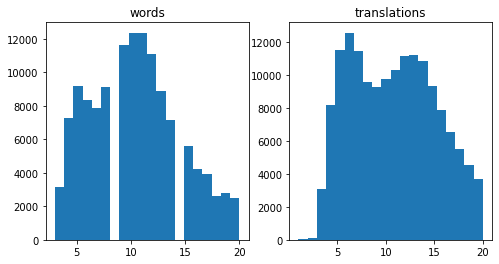

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("words")
plt.hist(list(map(len, all_words)), bins=20)

plt.subplot(1, 2, 2)
plt.title('translations')
plt.hist(list(map(len, all_translations)), bins=20)

### Step 3: deploy encoder-decoder 

__assignment starts here__

Our architecture consists of two main blocks:
* Encoder reads words character by character and outputs code vector (usually a function of last RNN state)
* Decoder takes that code vector and produces translations character by character

Than it gets fed into a model that follows this simple interface:
* __`model(inp, out, **flags) -> logp`__ - takes symbolic int32 matrices of hebrew words and their english translations. Computes the log-probabilities of all possible english characters given english prefices and hebrew word.
* __`model.translate(inp, **flags) -> out, logp`__ - takes symbolic int32 matrix of hebrew words, produces output tokens sampled from the model and output log-probabilities for all possible tokens at each tick.
  * if given flag __`greedy=True`__, takes most likely next token at each iteration. Otherwise samples with next token probabilities predicted by model.

That's all! It's as hard as it gets. With those two methods alone you can implement all kinds of prediction and training.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [13]:
from basic_model_torch import BasicTranslationModel
model = BasicTranslationModel(inp_voc, out_voc,
                              emb_size=64, hid_size=256)

In [14]:
# Play around with symbolic_translate and symbolic_score
inp = torch.tensor(np.random.randint(0, 10, [3, 5]), dtype=torch.int64)
out = torch.tensor(np.random.randint(0, 10, [3, 5]), dtype=torch.int64)

# translate inp (with untrained model)
sampled_out, logp = model.translate(inp, greedy=False)

print("Sample translations:\n", sampled_out)
print("Log-probabilities at each step:\n", logp)

Sample translations:
 tensor([[  0,  82, 168, 270,  23,  70, 169, 129, 160, 230, 186, 156,  34,  30,
         261, 192,  41, 123, 228, 221, 262, 221, 251, 221, 226, 264, 172, 223,
         166, 280,  73,   6,   1,  56,  87, 269, 187, 135, 122, 222, 139, 204,
          44, 188, 118,   7, 125, 125, 228, 105, 146, 204, 222, 209, 152, 206,
           3, 124, 130, 158, 123, 205,   0, 159,  72, 150, 144,  96, 220, 274,
         125,  50,  22, 280,  71, 213,  96, 261,  31,  94, 146, 187,   9,  23,
          52, 160, 271, 140,  46, 155, 253,  55, 220,  55,  16, 103,  77,  10,
         117,  79,  29, 143,   5, 197, 236,  11, 149, 240,  34, 239, 279, 118,
         190,  70, 147, 248, 254, 191, 167,  16, 128,  35, 104,  34, 231,  81,
         143, 113,  27,  91],
        [  0, 196,  26,   4, 190,  12, 140, 207,  49, 206,  80,  60, 224, 273,
          63,  14,  68, 261, 183, 260, 131,  77, 108, 204, 142,  49, 257, 271,
         236, 250, 175, 142,  31, 116, 180,  32, 129,  96,   1, 188, 138, 265,


In [15]:
sampled_out.shape

torch.Size([3, 130])

In [16]:
# score logp(out | inp) with untrained input
logp = model(inp, out)
print("Symbolic_score output:\n", logp)

print("Log-probabilities of output tokens:\n",
      torch.gather(logp, dim=2, index=out[:, :, None]))

Symbolic_score output:
 tensor([[[  0.0000, -69.0776, -69.0776,  ..., -69.0776, -69.0776, -69.0776],
         [ -5.7284,  -5.5916,  -5.6112,  ...,  -5.6923,  -5.6465,  -5.6945],
         [ -5.7442,  -5.5386,  -5.6952,  ...,  -5.6416,  -5.6703,  -5.6856],
         [ -5.6810,  -5.4891,  -5.5951,  ...,  -5.6816,  -5.7207,  -5.6646],
         [ -5.7450,  -5.5004,  -5.7032,  ...,  -5.6233,  -5.7182,  -5.6389]],

        [[  0.0000, -69.0776, -69.0776,  ..., -69.0776, -69.0776, -69.0776],
         [ -5.6349,  -5.6581,  -5.5220,  ...,  -5.5617,  -5.7076,  -5.4889],
         [ -5.6269,  -5.7540,  -5.6763,  ...,  -5.4099,  -5.6553,  -5.5890],
         [ -5.6105,  -5.6940,  -5.7020,  ...,  -5.5840,  -5.6573,  -5.6199],
         [ -5.5935,  -5.7557,  -5.7942,  ...,  -5.6302,  -5.6825,  -5.6521]],

        [[  0.0000, -69.0776, -69.0776,  ..., -69.0776, -69.0776, -69.0776],
         [ -5.7753,  -5.6225,  -5.6626,  ...,  -5.6537,  -5.6658,  -5.7740],
         [ -5.7027,  -5.5346,  -5.5558,  ...,  -

In [18]:
def translate(lines, max_len=MAX_OUTPUT_LENGTH):
    """
    You are given a list of input lines. 
    Make your neural network translate them.
    :return: a list of output lines
    """
    # Convert lines to a matrix of indices
    lines_ix = inp_voc.to_matrix(lines)
    lines_ix = torch.tensor(lines_ix, dtype=torch.int64)

    # Compute translations in form of indices
    trans_ix, _ = model.translate(lines_ix, greedy=True, max_len=max_len) # <YOUR CODE >

    # Convert translations back into strings
    return out_voc.to_lines(trans_ix.data.numpy())

In [19]:
print("Sample inputs:", all_words[:3])
print("Dummy translations:", translate(all_words[:3]))
trans = translate(all_words[:3])

assert translate(all_words[:3]) == translate(
    all_words[:3]), "make sure translation is deterministic (use greedy=True and disable any noise layers)"
assert type(translate(all_words[:3])) is list and (type(translate(all_words[:1])[0]) is str or type(
    translate(all_words[:1])[0]) is unicode), "translate(lines) must return a sequence of strings!"
# note: if translation freezes, make sure you used max_len parameter
print("Tests passed!")

Sample inputs: ['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו']
Dummy translations: ['וœnп+ỏ白½ղ-----5----', 'рוõס守סm星星ع‘‘ů---סm星', 'וœnп+ỏ白½ղ-----5----']
Tests passed!


### Scoring function

LogLikelihood is a poor estimator of model performance.
* If we predict zero probability once, it shouldn't ruin entire model.
* It is enough to learn just one translation if there are several correct ones.
* What matters is how many mistakes model's gonna make when it translates!

Therefore, we will use minimal Levenshtein distance. It measures how many characters do we need to add/remove/replace from model translation to make it perfect. Alternatively, one could use character-level BLEU/RougeL or other similar metrics.

The catch here is that Levenshtein distance is not differentiable: it isn't even continuous. We can't train our neural network to maximize it by gradient descent.

In [22]:
import editdistance  # !pip install editdistance


def get_distance(word, trans):
    """
    A function that takes word and predicted translation
    and evaluates (Levenshtein's) edit distance to closest correct translation
    """
    references = word_to_translation[word]
    assert len(references) != 0, "wrong/unknown word"
    return min(editdistance.eval(trans, ref) for ref in references)


def score(words, bsize=100):
    """a function that computes levenshtein distance for bsize random samples"""
    assert isinstance(words, np.ndarray)

    batch_words = np.random.choice(words, size=bsize, replace=False)
    batch_trans = translate(batch_words)

    distances = list(map(get_distance, batch_words, batch_trans))

    return np.array(distances, dtype='float32')

In [23]:
# should be around 5-50 and decrease rapidly after training :)
[score(test_words, 10).mean() for _ in range(5)]

[18.8, 19.0, 18.9, 18.6, 18.8]

### Supervised pre-training

Here we define a function that trains our model through maximizing log-likelihood a.k.a. minimizing crossentropy.

In [32]:
import random


def sample_batch(words, word_to_translation, batch_size):
    """
    sample random batch of words and random correct translation for each word
    example usage:
    batch_x,batch_y = sample_batch(train_words, word_to_translations,10)
    """
    # choose words
    batch_words = np.random.choice(words, size=batch_size)

    # choose translations
    batch_trans_candidates = list(map(word_to_translation.get, batch_words))
    batch_trans = list(map(random.choice, batch_trans_candidates))
    return batch_words, batch_trans

In [33]:
bx, by = sample_batch(train_words, word_to_translation, batch_size=3)
print("Source:")
print(bx)
print("Target:")
print(by)

Source:
['ליינץ' 'לינוס פאולינג' 'יער אפינג']
Target:
['lienz', 'linus pauling', 'epping forest']


In [37]:
from basic_model_torch import infer_length, infer_mask, to_one_hot


def compute_loss_on_batch(input_sequence, reference_answers):
    """ Compute crossentropy loss given a batch of sources and translations """
    input_sequence = torch.tensor(inp_voc.to_matrix(input_sequence), dtype=torch.int64)
    reference_answers = torch.tensor(out_voc.to_matrix(reference_answers), dtype=torch.int64)

    # Compute log-probabilities of all possible tokens at each step. Use model interface.
    logprobs_seq = model(input_sequence, reference_answers) # YOUR CODE

    # compute elementwise crossentropy as negative log-probabilities of reference_answers.
    crossentropy = - \
        torch.sum(logprobs_seq *
                  to_one_hot(reference_answers, len(out_voc)), dim=-1)
    assert crossentropy.dim(
    ) == 2, "please return elementwise crossentropy, don't compute mean just yet"

    # average with mask
    mask = infer_mask(reference_answers, out_voc.eos_ix)
    loss = torch.sum(crossentropy * mask) / torch.sum(mask)

    return loss

In [39]:
# test it
loss = compute_loss_on_batch(*sample_batch(train_words, word_to_translation, 3))
print('loss = ', loss)

assert loss.item() > 0.0
loss.backward()
for w in model.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).item() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check comput_loss_on_batch." % (
            w.size(),)
print('Seems fine!')

loss =  tensor(5.2917, grad_fn=<DivBackward0>)
Seems fine!


##### Actually train the model

Minibatches and stuff...

In [40]:
from IPython.display import clear_output
from tqdm import tqdm, trange  # or use tqdm_notebook,tnrange

loss_history = []
editdist_history = []
entropy_history = []
opt = torch.optim.Adam(model.parameters())

llh=1.417, mean score=6.941


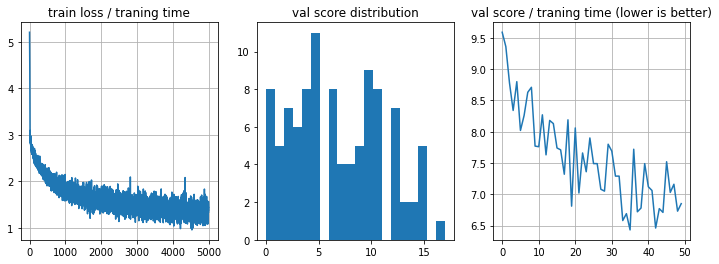

100%|██████████| 5000/5000 [07:14<00:00, 11.51it/s]


In [41]:


for i in trange(5000):
    loss = compute_loss_on_batch(*sample_batch(train_words, word_to_translation, 32))

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    loss_history.append(loss.item())

    if (i+1) % REPORT_FREQ == 0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        print("llh=%.3f, mean score=%.3f" %
              (np.mean(loss_history[-10:]), np.mean(editdist_history[-10:])))
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.title('train loss / traning time')
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(132)
        plt.title('val score distribution')
        plt.hist(current_scores, bins=20)
        plt.subplot(133)
        plt.title('val score / traning time (lower is better)')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()

__How to interpret the plots:__

* __Train loss__ - that's your model's crossentropy over minibatches. It should go down steadily. Most importantly, it shouldn't be NaN :)
* __Val score distribution__ - distribution of translation edit distance (score) within batch. It should move to the left over time.
* __Val score / training time__ - it's your current mean edit distance. This plot is much whimsier than loss, but make sure it goes below 8 by 2500 steps. 

If it doesn't, first try to re-create both model and opt. You may have changed it's weight too much while debugging. If that doesn't help, it's debugging time.

In [42]:
for word in train_words[:10]:
    print("%s -> %s" % (word, translate([word])[0]))

כל אנשי סמיילי -> salim shili
קטגוריה:ערוץ 2 -> shabet
עבודה מהבית -> mathe bath
פראליה -> paralia
קפלר 42 -> capler 44
קטגוריה:מתאסלמים -> mathmals
בושמי -> bushmi
לאונרדו -> lonardo
שאמה -> shama
עכברה -> catter


In [43]:
test_scores = []
for start_i in trange(0, len(test_words), 32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance, batch_words, batch_trans))
    test_scores.extend(distances)

print("Supervised test score:", np.mean(test_scores))

100%|██████████| 407/407 [00:09<00:00, 40.93it/s]

Supervised test score: 6.858207808177068


### Self-critical policy gradient

In this section you'll implement algorithm called self-critical sequence training (here's an [article](https://arxiv.org/abs/1612.00563)).

The algorithm is a vanilla policy gradient with a special baseline. 

$$ \nabla J = E_{x \sim p(s)} E_{y \sim \pi(y|x)} \nabla log \pi(y|x) \cdot (R(x,y) - b(x)) $$

Here reward R(x,y) is a __negative levenshtein distance__ (since we minimize it). The baseline __b(x)__ represents how well model fares on word __x__.

In practice, this means that we compute baseline as a score of greedy translation, $b(x) = R(x,y_{greedy}(x)) $.

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/scheme.png)


Luckily, we already obtained the required outputs: `model.greedy_translations, model.greedy_mask` and we only need to compute levenshtein using `compute_levenshtein` function.


In [47]:
def compute_reward(input_sequence, translations):
    """ computes sample-wise reward given token ids for inputs and translations """
    distances = list(map(get_distance,
                         inp_voc.to_lines(input_sequence.data.numpy()),
                         out_voc.to_lines(translations.data.numpy())))
    # use negative levenshtein distance so that larger reward means better policy
    return - torch.tensor(distances, dtype=torch.int64)

In [75]:
def scst_objective_on_batch(input_sequence, max_len=MAX_OUTPUT_LENGTH):
    """ Compute pseudo-loss for policy gradient given a batch of sources """
    input_sequence = torch.tensor(inp_voc.to_matrix(input_sequence), dtype=torch.int64)

    # use model to __sample__ symbolic translations given input_sequence
    sample_translations, sample_logp = model.translate(input_sequence, greedy=False, max_len=max_len) # YOUR CODE
    # use model to __greedy__ symbolic translations given input_sequence
    greedy_translations, greedy_logp = model.translate(input_sequence, greedy=True, max_len=max_len) # YOUR CODE

    # compute rewards and advantage
    rewards = compute_reward(input_sequence, sample_translations)
    baseline = compute_reward(input_sequence, greedy_translations) #<compute __negative__ levenshtein for greedy mode >

    # compute advantage using rewards and baseline
    advantage = (rewards - baseline).detach() # YOUR CODE

    # compute log_pi(a_t|s_t), shape = [batch, seq_length]
    #print('\n', sample_logp.shape)
    logp_sample = torch.gather(sample_logp, dim=2, index=sample_translations[:, :, None]).squeeze(-1) # YOUR CODE
    
    # ^-- hint: look at how crossentropy is implemented in supervised learning loss above
    # mind the sign - this one should not be multiplied by -1 :)

    # policy gradient pseudo-loss. Gradient of J is exactly policy gradient.
    J = logp_sample * advantage[:, None]

    assert J.dim() == 2, "please return elementwise objective, don't compute mean just yet"

    # average with mask
    mask = infer_mask(sample_translations, out_voc.eos_ix)
    loss = - torch.sum(J * mask) / torch.sum(mask)

    # regularize with negative entropy. Don't forget the sign!
    # note: for entropy you need probabilities for all tokens (sample_logp), not just logp_sample
    entropy = - torch.sum(torch.exp(sample_logp) * sample_logp, dim=-1) 
    #<compute entropy matrix of shape[batch, seq_length], H = -sum(p*log_p), don't forget the sign!>
    # hint: you can get sample probabilities from sample_logp using math :)

    assert entropy.dim(
    ) == 2, "please make sure elementwise entropy is of shape [batch,time]"

    reg = - 0.01 * torch.sum(entropy * mask) / torch.sum(mask)

    return loss + reg, torch.sum(entropy * mask) / torch.sum(mask)

### Policy gradient training


In [76]:
entropy_history = [np.nan] * len(loss_history)
opt = torch.optim.Adam(model.parameters(), lr=1e-5)

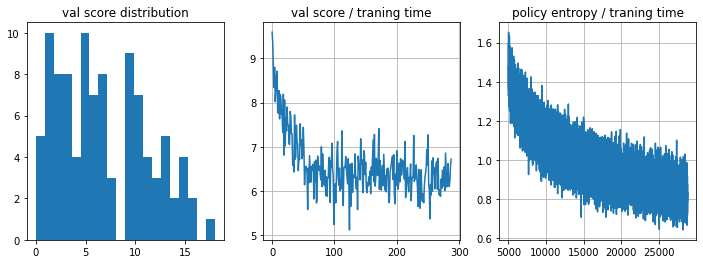

 24%|██▍       | 23802/100000 [41:28<3:19:25,  6.37it/s]

J=-0.690, mean score=6.408


 24%|██▍       | 23841/100000 [41:32<1:59:22, 10.63it/s]

In [ ]:
for i in trange(100000):
    loss, ent = scst_objective_on_batch(
        sample_batch(train_words, word_to_translation, 32)[0])  # [0] = only source sentence

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    loss_history.append(loss.item())
    entropy_history.append(ent.item())

    if (i+1) % REPORT_FREQ == 0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.title('val score distribution')
        plt.hist(current_scores, bins=20)
        plt.subplot(132)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.subplot(133)
        plt.title('policy entropy / traning time')
        plt.plot(entropy_history)
        plt.grid()
        plt.show()
        print("J=%.3f, mean score=%.3f" %
              (np.mean(loss_history[-10:]), np.mean(editdist_history[-10:])))

__Debugging tips:__
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/do_something_scst.png)

 * As usual, don't expect improvements right away, but in general the model should be able to show some positive changes by 5k steps.
 * Entropy is a good indicator of many problems. 
   * If it reaches zero, you may need greater entropy regularizer.
   * If it has rapid changes time to time, you may need gradient clipping.
   * If it oscillates up and down in an erratic manner... it's perfectly okay for entropy to do so. But it should decrease at the end.
   
 * We don't show loss_history cuz it's uninformative for pseudo-losses in policy gradient. However, if something goes wrong you can check it to see if everything isn't a constant zero.

### Results

In [ ]:
for word in train_words[:10]:
    print("%s -> %s" % (word, translate([word])[0]))

In [ ]:
test_scores = []
for start_i in trange(0, len(test_words), 32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance, batch_words, batch_trans))
    test_scores.extend(distances)
print("Supervised test score:", np.mean(test_scores))

# ^^ If you get Out Of MemoryError, please replace this with batched computation

### Bonus area: Make it actually work

In this section we want you to finally __restart with EASY_MODE=False__ and experiment to find a good model/curriculum for that task.

We recommend you to start with the following architecture

```
encoder---decoder

           P(y|h)
             ^
 LSTM  ->   LSTM
  ^          ^
 biLSTM  ->   LSTM
  ^          ^
input       y_prev
```

__Note:__ you can fit all 4 state tensors of both LSTMs into a in a single state - just assume that it contains, for example, [h0, c0, h1, c1] - pack it in encode and update in decode.


Here are some cool ideas on what you can do then.

__General tips & tricks:__
* You will likely need to adjust pre-training time for such a network.
* Supervised pre-training may benefit from clipping gradients somehow.
* SCST may indulge a higher learning rate in some cases and changing entropy regularizer over time.
* It's often useful to save pre-trained model parameters to not re-train it every time you want new policy gradient parameters. 
* When leaving training for nighttime, try setting REPORT_FREQ to a larger value (e.g. 500) not to waste time on it.

__Formal criteria:__
Build an architecture that:
* _doesn't consist of single GRU_
* _works better_ than single GRU baseline. 
* We also want you to provide either learning curve or trained model, preferably both
* ... and write a brief report or experiment log describing what you did and how it fared.

### Attention
There's more than one way to connect decoder to encoder
  * __Vanilla:__ layer_i of encoder last state goes to layer_i of decoder initial state
  * __Every tick:__ feed encoder last state _on every iteration_ of decoder.
  * __Attention:__ allow decoder to "peek" at one (or several) positions of encoded sequence on every tick.
  
The most effective (and cool) of those is, of course, attention.
You can read more about attention [in this nice blog post](https://distill.pub/2016/augmented-rnns/). The easiest way to begin is to use "soft" attention with "additive" or "dot-product" intermediate layers.

__Tips__
* Model usually generalizes better if you no longer allow decoder to see final encoder state
* Once your model made it through several epochs, it is a good idea to visualize attention maps to understand what your model has actually learned

* There's more stuff [here](https://github.com/yandexdataschool/Practical_RL/blob/master/week8_scst/bonus.ipynb)
* If you opted for hard attention, we recommend [gumbel-softmax](https://blog.evjang.com/2016/11/tutorial-categorical-variational.html) instead of sampling. Also please make sure soft attention works fine before you switch to hard.

### UREX
* This is a way to improve exploration in policy-based settings. The main idea is that you find and upweight under-appreciated actions.
* Here's [video](https://www.youtube.com/watch?v=fZNyHoXgV7M&feature=youtu.be&t=3444)
 and an [article](https://arxiv.org/abs/1611.09321).
* You may want to reduce batch size 'cuz UREX requires you to sample multiple times per source sentence.
* Once you got it working, try using experience replay with importance sampling instead of (in addition to) basic UREX.

### Some additional ideas:
* (advanced deep learning) It may be a good idea to first train on small phrases and then adapt to larger ones (a.k.a. training curriculum).
* (advanced nlp) You may want to switch from raw utf8 to something like unicode or even syllables to make task easier.
* (advanced nlp) Since hebrew words are written __with vowels omitted__, you may want to use a small Hebrew vowel markup dataset at `he-pron-wiktionary.txt`.



In [ ]:
assert not EASY_MODE, "make sure you set EASY_MODE = False at the top of the notebook."

`[your report/log here or anywhere you please]`

__Contributions:__ This notebook is brought to you by
* Yandex [MT team](https://tech.yandex.com/translate/)
* Denis Mazur ([DeniskaMazur](https://github.com/DeniskaMazur)), Oleg Vasilev ([Omrigan](https://github.com/Omrigan/)), Dmitry Emelyanenko ([TixFeniks](https://github.com/tixfeniks)) and Fedor Ratnikov ([justheuristic](https://github.com/justheuristic/))
* Dataset is parsed from [Wiktionary](https://en.wiktionary.org), which is under CC-BY-SA and GFDL licenses.
